In [1]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 10]

In [2]:
stockReturn = pd.read_csv('stock_returns_2018.csv')
stockReturn.index = pd.to_datetime(stockReturn['date'])
stockReturn.drop('date', axis=1, inplace=True)
stockReturn.head()

,IBM,GE,LLY,F,BAC,KR,ITUB,GG,SIRI,ACB,...,T,ECA,ABEV,CVS,MRVL,CSCO,MO,BMY,WFC,HBAN
date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.027117,0.009411,0.005418,0.007868,-0.003350,-0.016029,0.013216,0.008286,0.000000,0.176503,...,-0.023364,0.005814,0.006033,-0.004362,0.030608,0.007946,-0.003682,0.000815,0.007664,0.008186
2018-01-03,0.020051,0.020721,0.004453,0.017094,0.013002,-0.031737,0.012323,0.004491,0.019012,-0.079085,...,0.009253,-0.024204,-0.001505,0.026025,0.022463,-0.004606,-0.003981,0.006336,0.012431,0.008793
2018-01-04,0.004874,0.000539,0.012203,0.016807,0.004627,0.012523,0.012173,0.002238,0.003759,0.015195,...,0.003677,-0.008949,0.004508,0.043242,-0.017669,0.013755,0.002845,0.002265,0.006716,0.008716
2018-01-05,0.006013,-0.014123,-0.005096,-0.003795,-0.006948,0.023513,-0.013615,0.008163,-0.003759,0.052777,...,0.002880,-0.003001,-0.007525,-0.008706,0.007364,0.010318,-0.001279,0.000323,-0.011379,-0.002005
2018-01-08,0.002200,0.015201,-0.000813,-0.005337,0.004968,-0.007176,-0.013072,0.000000,0.000000,-0.022056,...,-0.020069,0.024491,-0.006061,-0.001029,-0.000864,-0.006279,-0.010581,-0.000970,0.003540,0.018556


expected return of Sharpe optimal portfolio: -0.014050835967157133
volatility of Sharpe optimal portfolio: 0.03735928258186432


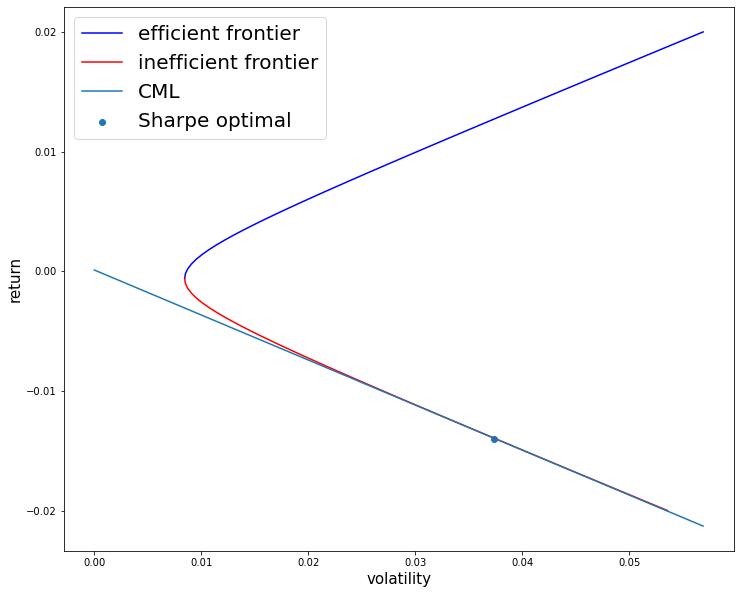

In [3]:
# basic information
avgReturn = stockReturn.mean(axis=0)
covMatrix = stockReturn.cov(ddof=1)

# efficient frontier of the market (fix the risk, then maximize the expected return)
A11 = np.matrix(2 * covMatrix)
A21 = np.matrix(
    np.concatenate([
        avgReturn.values.reshape(1, len(avgReturn)),
        np.ones([1, len(avgReturn)])
    ],
                   axis=0))
A12 = -1 * A21.T
A22 = np.matrix(np.zeros([2, 2]))
A1 = np.concatenate([A11, A12], axis=1)
A2 = np.concatenate([A21, A22], axis=1)

A = np.concatenate([A1, A2], axis=0)
b = np.matrix(np.zeros([len(avgReturn) + 2, 1]))
b[-1, 0] = 1
y = np.linspace(-0.02, 0.02, 100)
X = []
for r in y:
    b[-2, 0] = r
    weights = np.linalg.inv(A) * b
    weights = weights[:-2, 0]
    risk = np.sqrt(weights.T * np.matrix(covMatrix.values) * weights)[0, 0]
    X.append(risk)
X = np.array(X)

plt.plot(X[X.argmin():], y[X.argmin():], c='b')
plt.plot(X[:X.argmin() + 1], y[:X.argmin() + 1], c='r')
plt.xlabel('volatility', fontsize=15)
plt.ylabel('return', fontsize=15)

# Sharpe optimal portfolio
riskFreeRate = 1e-4


def objFun(x, info=False):
    weights = np.matrix(x).T
    excessReturn = np.matrix(avgReturn - riskFreeRate) * weights
    volatility = np.sqrt(weights.T * np.matrix(covMatrix) * weights)
    Sharpe = excessReturn / volatility
    if info:
        return Sharpe[0, 0], excessReturn[0, 0], volatility[0, 0]
    else:
        return Sharpe[0, 0]


cons = {'type': 'eq', 'fun': lambda x: sum(x) - 1}
res = opt.minimize(objFun, [1 / len(avgReturn)] * avgReturn, constraints=cons)
X = np.linspace(0, X.max(), 100)
y = res['fun'] * X + riskFreeRate
plt.plot(X, y)

_, exRet, vol = objFun(res['x'], info=True)
print('expected return of Sharpe optimal portfolio:', exRet)
print('volatility of Sharpe optimal portfolio:', vol)
plt.scatter(vol, exRet)
plt.legend(
    ['efficient frontier', 'inefficient frontier', 'CML', 'Sharpe optimal'],
    fontsize=20)
plt.show()

In [4]:
# CAPM, note that the Sharpe optimal portfolio can be seen as the market portfolio
CAPM = pd.Series(index=avgReturn.index, name='CAPM', dtype='float')
for stock in CAPM.index:
    CAPM[stock] = np.matrix(covMatrix.loc[stock]) * np.matrix(
        res['x']).T / vol**2 * exRet + riskFreeRate
CAPM - avgReturn
# RK: the result below showcases the maturity of the US financial market.

IBM    -3.974993e-06
GE      1.232513e-06
LLY     5.927098e-06
F       4.673925e-06
BAC     1.910536e-06
KR      1.694707e-06
ITUB   -2.448370e-06
GG      9.714902e-07
SIRI    4.532700e-06
ACB     2.568160e-05
VALE   -1.524625e-06
PFE    -6.411520e-06
CTL    -3.838290e-06
T      -3.977829e-06
ECA     8.920424e-06
ABEV   -8.636777e-07
CVS     2.843968e-06
MRVL    4.937199e-06
CSCO    2.120793e-06
MO     -3.029372e-06
BMY    -4.668252e-07
WFC    -8.662509e-07
HBAN    2.177344e-06
dtype: float64